# Overview

This notebook will walk you through the process of converting your logical circuits to physical circuits. We'll be using the GHZ state as a running example.

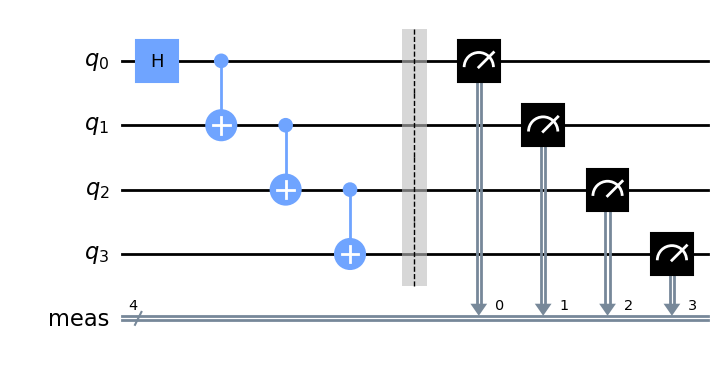

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.measure_all()

qc.draw('mpl', style='clifford')

Suppose we want to perform this fault-tolerantly (up to a single qubit error). We'd need to perform logical state preparation of $\ket{\bar{0}}$, then synthesize all the logical operations to physical operations. We'd also need syndrome checks and a final fault-tolerant logical measurement. Fortunately, the transpiler takes care of all this.

We'll let it add 1 syndrome check. With the single syndrome check in the middle, this circuit gets considerably bigger. Notice that the transpiler treated the $k = 4$ original qubits $q_0, \dots, q_3$ as logical qubits and added the physical qubits required ($a_0, a_1, t, b$).

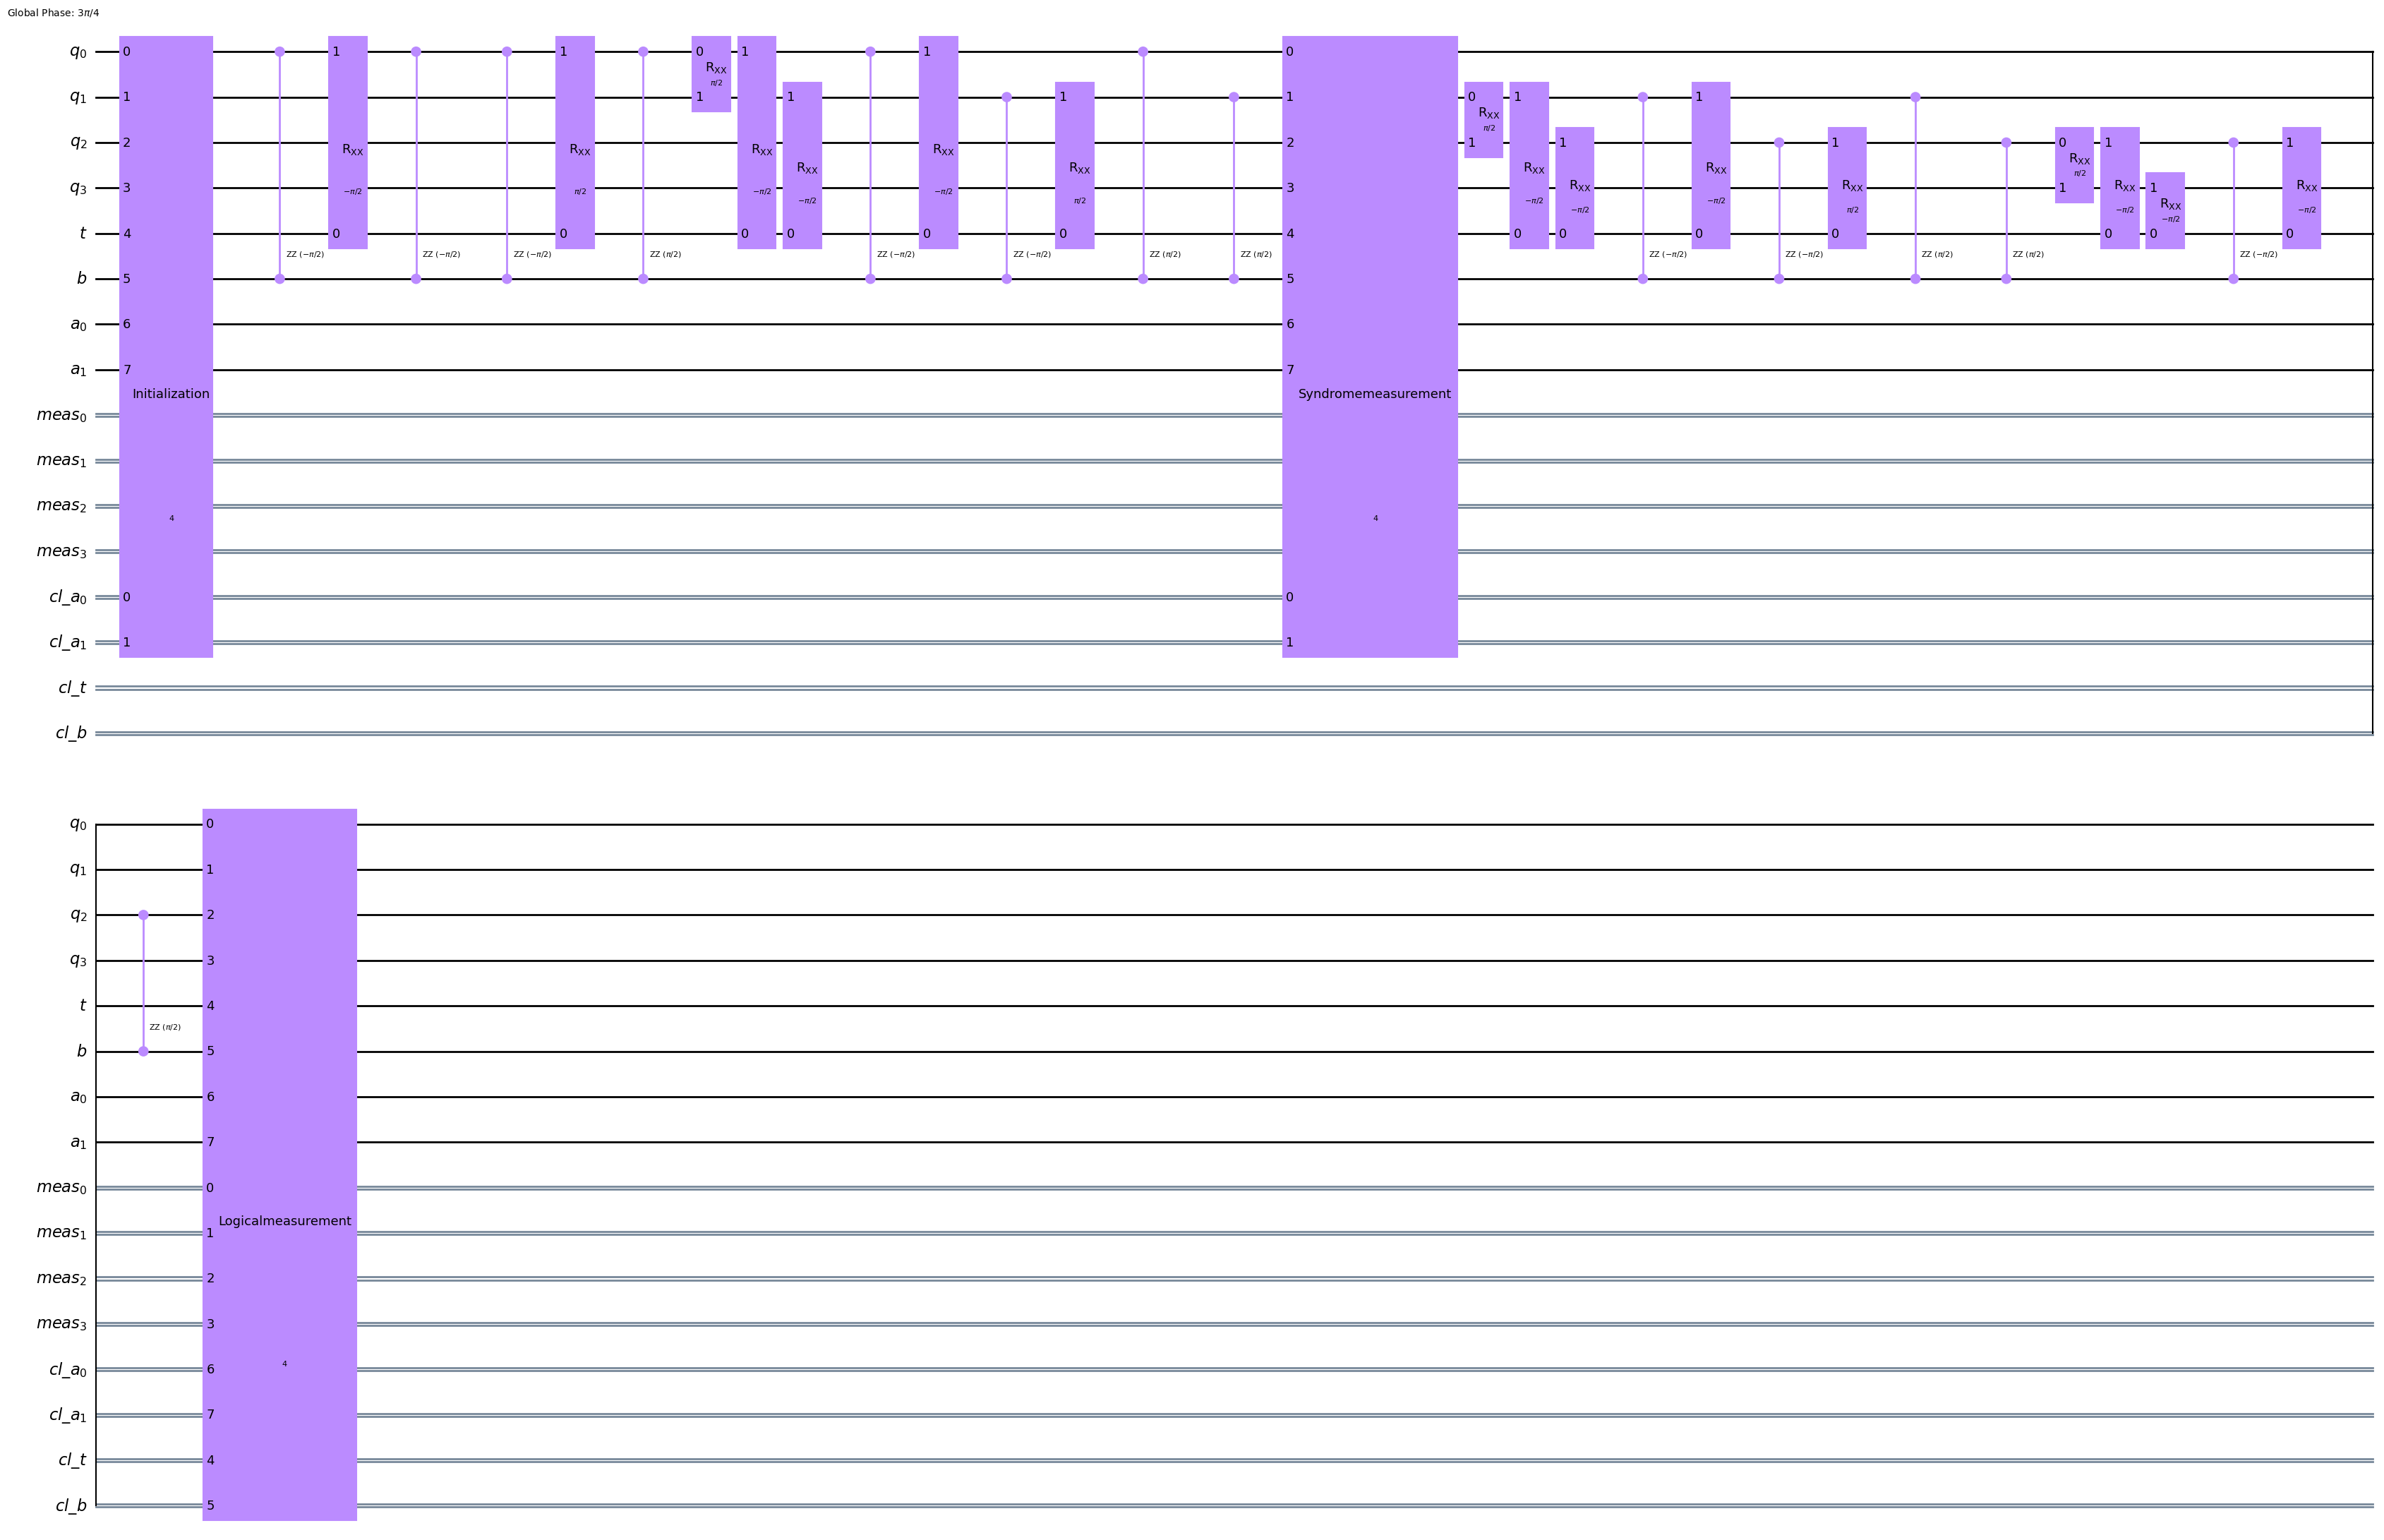

In [3]:
from qiskit_iceberg_transpiler import transpile

physical_circuit = transpile(qc, syndrome_checks=1)

physical_circuit.draw('mpl', style='clifford', cregbundle=False, fold=50)

You can also see that the transpiler converted our logical operations into the logical basis set of the iceberg code. Single-qubit operations turn into two-qubit operations on the original qubit and either $t$ or $b$. Ultimately, the transpiler goes through the following steps:

1. It translates all gates to the universal basis set $\{X, Z, R_X, R_Z, R_{XX}, R_{YY}, R_{ZZ}\}$. These are the sets of logical operators that can be implemented in the iceberg code. All logical equivalents operate on 2 qubits, so **this will considerably increase your gate depth**.

2. Treating the circuit as a set of logical gates, we add syndrome measurement placeholders. It's important that syndrome measurement is placed in such a way that it does not break apart logical operations. This is why the transpiler handles it before doing any further conversion.

3. The pass manager adds initial logical state preparation at the beginning and logical measurement at the end. If your original circuit had measurements, they are deleted. It also converts syndrome measurement placeholders into the real gates.

4. Now we convert all logical operators to their physical implementations (e.g. $\bar{X_i} \rightarrow X_iX_t$).

The resulting circuit is now a physical circuit that can be transpiled to native gates depending on the backend.

We can also manually place syndrome checks if we have special requirements and don't want to let the transpiler take care of it.

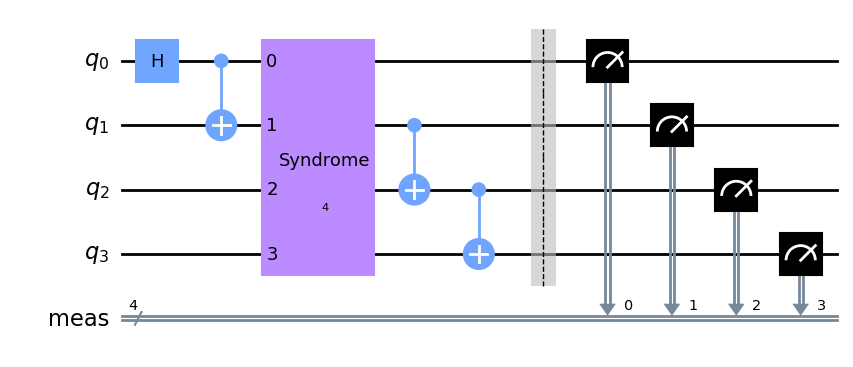

In [4]:
from qiskit import QuantumCircuit

from qiskit_iceberg_transpiler import Syndrome

qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.append(Syndrome(4), range(4))
qc.cx(1, 2)
qc.cx(2, 3)
qc.measure_all()

qc.draw("mpl", style="clifford")

The transpiler will replace this with the real `SyndromeMeasurement` gate after adding the ancilla and code qubits.

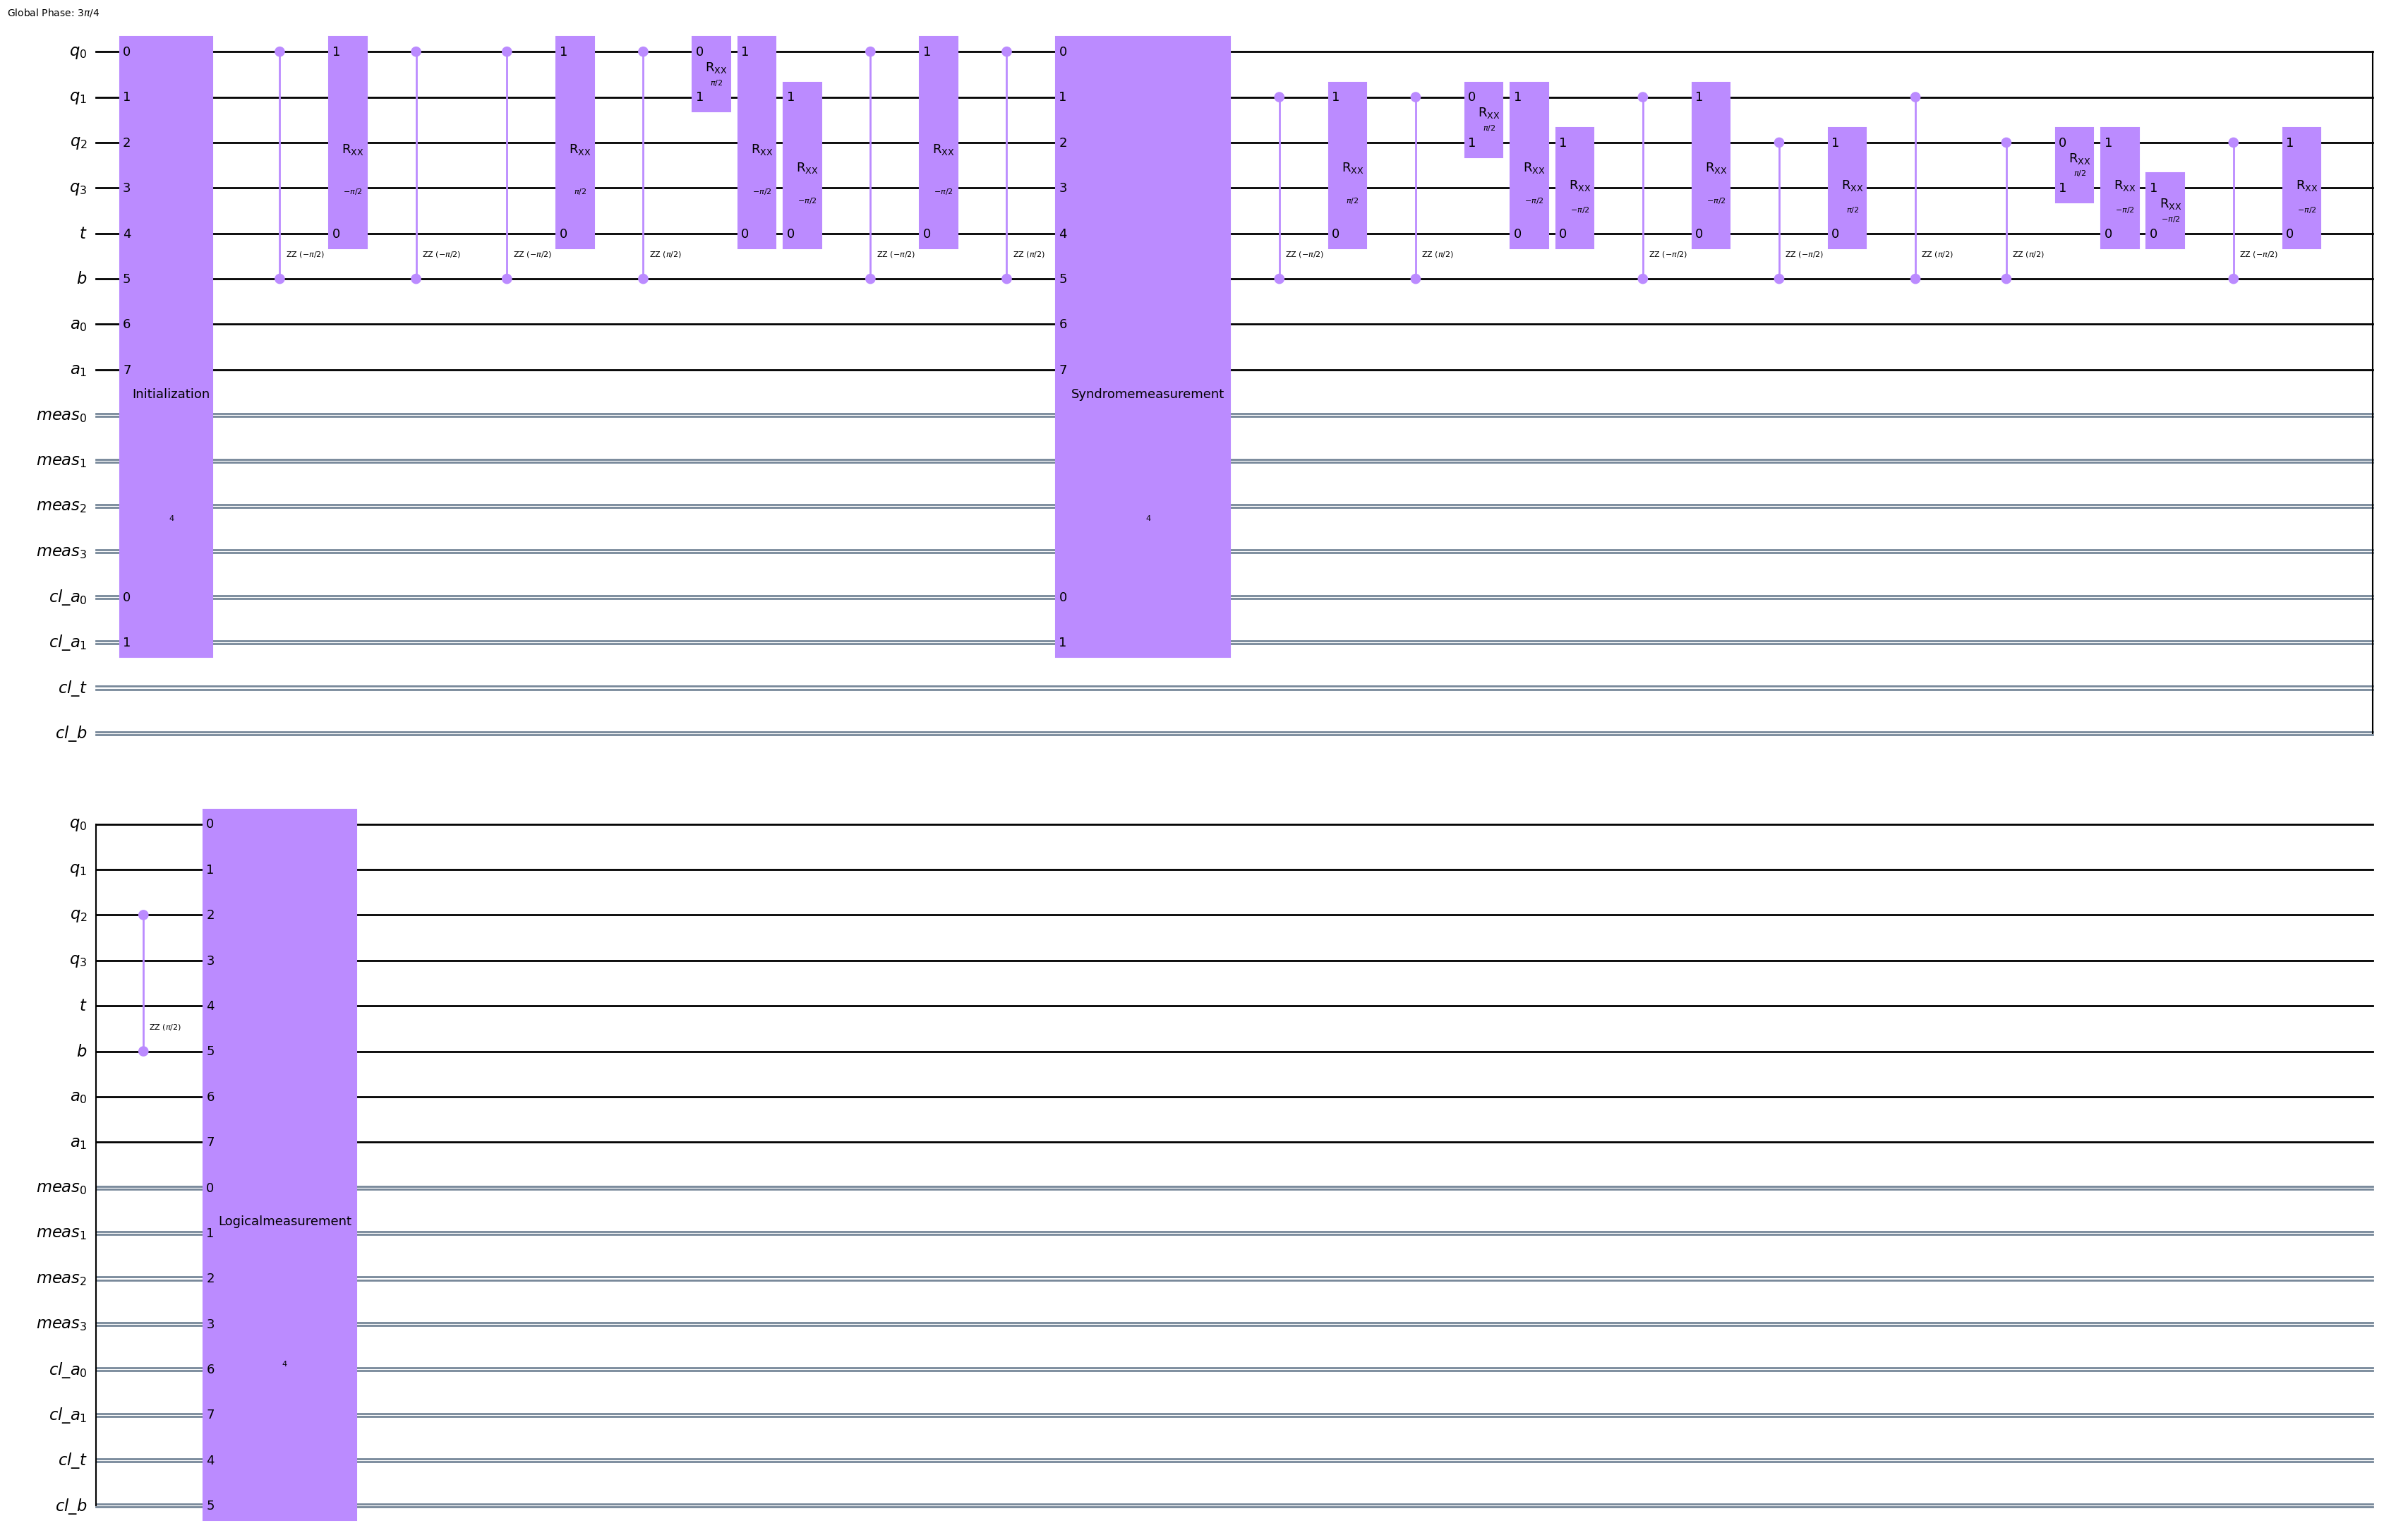

In [6]:
physical_circuit = transpile(qc)
physical_circuit.draw('mpl', style='clifford', cregbundle=False, fold=50)

Finally, we have to talk about one more option, `use_error_var`. New versions of Qiskit have tools for manipulating classical variables. The default transpiler settings assume you can perform mid-circuit measurement and reset (MCMR), and it also reuses the same classical ancilla register. This may be a problem since a future error-free measurement may overwrite a previous errored state, falsely leading us to believe nothing happened in our circuit.

To avoid this overrwrite, the default settings introduce an auxiliary variable `error` into the circuit, which contains the logical OR of each ancilla measurement. This way, if an error ever happens, we're sure that we'll catch it. You can see this operation in the QASM 3 serialization of the circuit (look for `error = cl_a | error`).

In [8]:
from qiskit.qasm3 import dumps

print(dumps(physical_circuit.decompose()))

OPENQASM 3.0;
include "stdgates.inc";
bit[4] meas;
bit[2] cl_a;
bit[1] cl_t;
bit[1] cl_b;
qubit[4] q;
qubit[1] t_0;
qubit[1] b;
qubit[2] a;
uint[2] error;
h t_0[0];
cx t_0[0], q[0];
cx q[0], q[1];
cx q[1], q[2];
cx q[2], q[3];
cx q[3], b[0];
barrier q[0], q[1], q[2], q[3], t_0[0], b[0], a[0], a[1];
cx t_0[0], a[0];
cx b[0], a[0];
cx b[0], q[0];
h t_0[0];
reset a[1];
h a[1];
rz(-pi/2) q[0];
cx b[0], q[0];
h q[0];
cx t_0[0], q[0];
rz(-pi/2) q[0];
cx t_0[0], q[0];
h t_0[0];
h t_0[0];
h q[0];
cx b[0], q[0];
rz(-pi/2) q[0];
cx b[0], q[0];
cx b[0], q[0];
rz(-pi/2) q[0];
cx b[0], q[0];
h q[0];
cx t_0[0], q[0];
rz(pi/2) q[0];
cx t_0[0], q[0];
h t_0[0];
h t_0[0];
h q[0];
cx b[0], q[0];
rz(pi/2) q[0];
cx b[0], q[0];
h q[0];
h q[1];
cx q[0], q[1];
rz(pi/2) q[1];
cx q[0], q[1];
h q[0];
h q[0];
cx t_0[0], q[0];
rz(-pi/2) q[0];
cx t_0[0], q[0];
h t_0[0];
h t_0[0];
h q[0];
cx b[0], q[0];
rz(-pi/2) q[0];
cx b[0], q[0];
h q[0];
h q[1];
h q[1];
cx t_0[0], q[1];
rz(-pi/2) q[1];
cx t_0[0], q[1];
h t_0[0];

Currently, I've tried running this on AerSimulator, and it just crashes. A simulator has to support the `Store` instruction for it to work. Same goes for the hardware. If you want to disable this behavior, the transpiler instead can introduce a new classical register for each syndrome measurement, state preparation, and measurement.

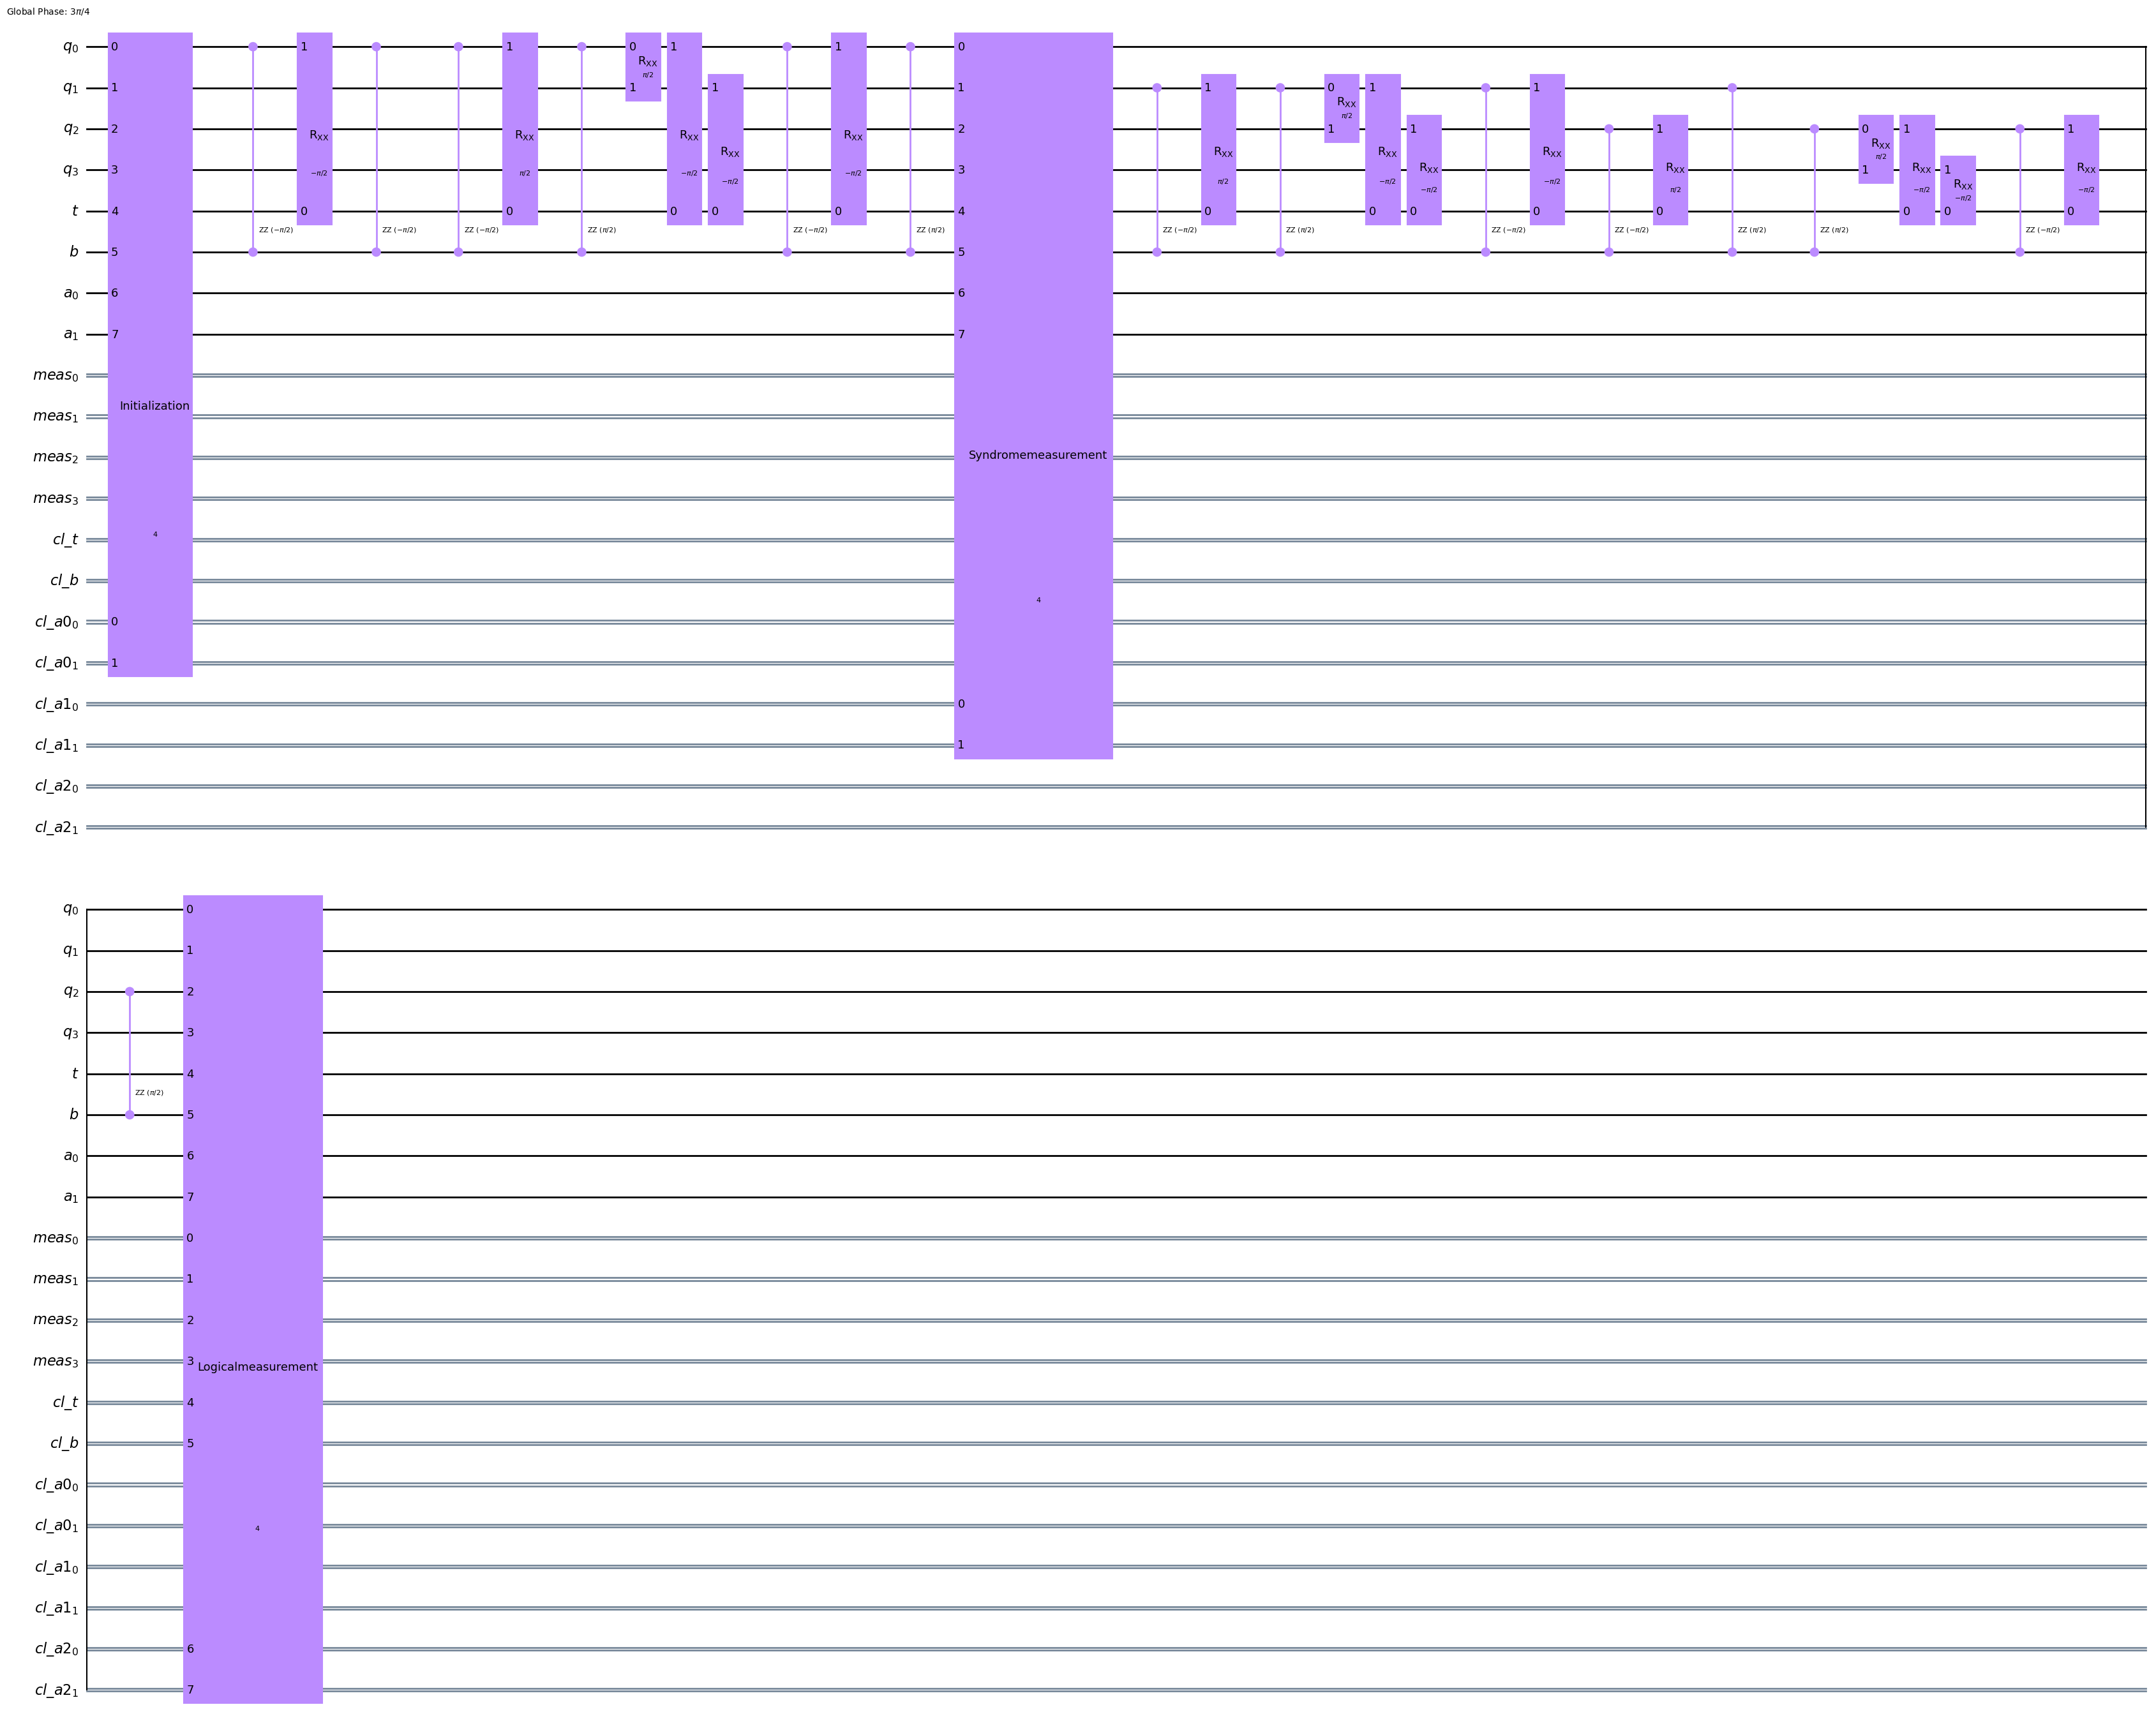

In [9]:
physical_circuit = transpile(qc, use_error_var=False)
physical_circuit.draw('mpl', style='clifford', cregbundle=False, fold=50)

Todo: Show utilities for extracting good bit strings and detecting errors from sampler results.